In [197]:
import pandas as pd

 Load and Prepare Data

In [198]:
df = pd.read_csv("../data/raw/bank/bank-full.csv", sep=";")

In [199]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [200]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [202]:
print(df.duplicated().sum())

0


In [203]:
dup = df[df.duplicated()]
dup

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [204]:
unknown_counts = (df == "unknown").sum()
unknown_counts

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [205]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load dataset
# df = pd.read_csv("your_dataset.csv")

# --- Handle outliers in 'balance' ---
# Clip balance at the 1st and 99th percentile
lower_bound = df['balance'].quantile(0.01)
upper_bound = df['balance'].quantile(0.99)
df['balance_clipped'] = df['balance'].clip(lower=lower_bound, upper=upper_bound)

# Use clipped balance to define treatment
median_balance = df['balance_clipped'].median()
df['treatment'] = (df['balance_clipped'] >= median_balance).astype(int)

# Define features for propensity score estimation (excluding target 'y')
X = df.drop(columns=['y', 'treatment', 'balance', 'balance_clipped'])
y = df['treatment']

# Convert categorical variables to dummies
X = pd.get_dummies(X, drop_first=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression for propensity scores
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

# --- Propensity Score Matching ---
caliper = 0.05

def match_sample(df):
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(1)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    balanced_df = pd.concat([treated, matched_control])
    return balanced_df

balanced_df = match_sample(df)

# Output final dataset
print(balanced_df[['balance', 'treatment', 'propensity_score']].head())


    balance  treatment  propensity_score
0      2143          1          0.581633
3      1506          1          0.484080
9       593          1          0.430160
20      723          1          0.286103
21      779          1          0.564425


In [206]:
# Winsorize to limit outliers in balance
df['balance_winsorized'] = df['balance'].clip(
    lower=df['balance'].quantile(0.01),
    upper=df['balance'].quantile(0.99)
)


/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_21988/2314164844.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_df[balanced_df['treatment'] == 1]['propensity_score'], label="Treated", shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_21988/2314164844.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_df[balanced_df['treatment'] == 0]['propensity_score'], label="Control", shade=True)
/opt/anaconda3/lib/python3.11/site-packages

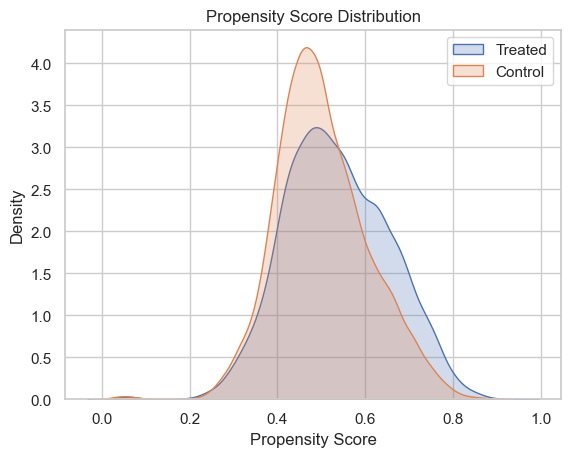

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(balanced_df[balanced_df['treatment'] == 1]['propensity_score'], label="Treated", shade=True)
sns.kdeplot(balanced_df[balanced_df['treatment'] == 0]['propensity_score'], label="Control", shade=True)
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Propensity Score Distribution")
plt.legend()
plt.show()


In [208]:
# Compute inverse probability weights
balanced_df['weights'] = balanced_df['treatment'] / balanced_df['propensity_score'] + (1 - balanced_df['treatment']) / (1 - balanced_df['propensity_score'])

# Check weight distribution
print(balanced_df['weights'].describe())


count    41263.000000
mean         2.052444
std          0.813899
min          1.020381
25%          1.684785
50%          1.929690
75%          2.260844
max         60.972777
Name: weights, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


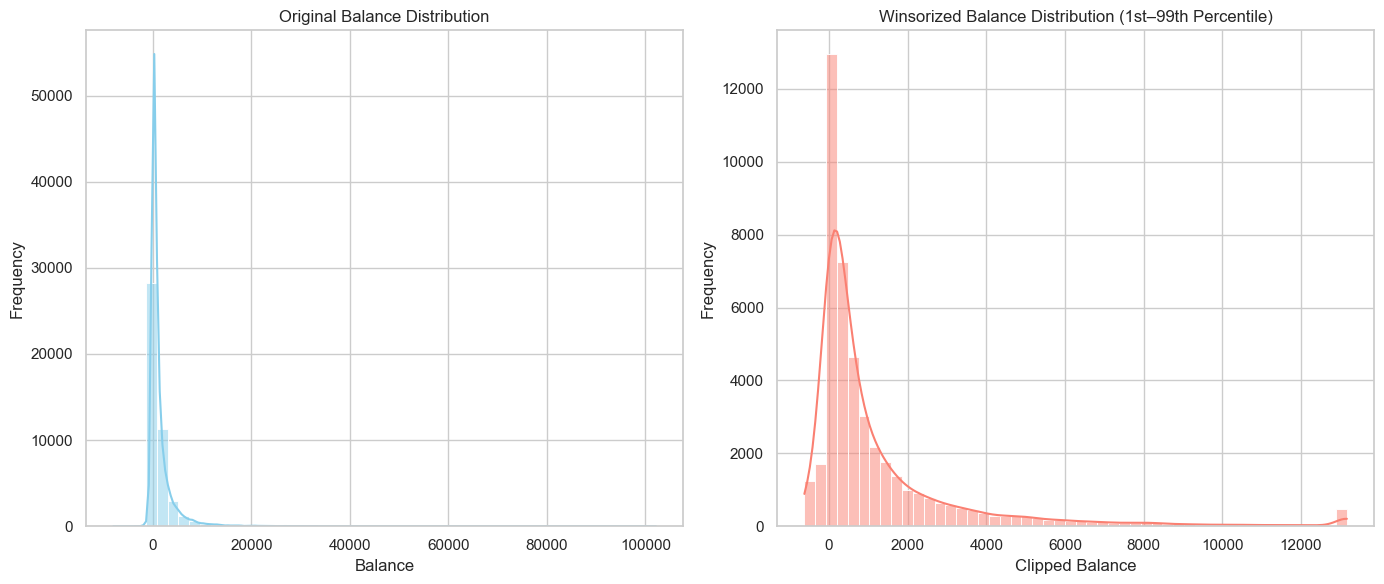

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot style
sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(14, 6))

# Plot original balance distribution
plt.subplot(1, 2, 1)
sns.histplot(df['balance'], bins=50, kde=True, color='skyblue')
plt.title('Original Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Plot clipped (Winsorized) balance distribution
plt.subplot(1, 2, 2)
sns.histplot(df['balance_clipped'], bins=50, kde=True, color='salmon')
plt.title('Winsorized Balance Distribution (1st–99th Percentile)')
plt.xlabel('Clipped Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [210]:
# Map 'yes' to 1 and 'no' to 0
balanced_df['y_numeric'] = balanced_df['y'].map({'yes': 1, 'no': 0})


In [211]:
# Separate treated and control groups
treated_matched = balanced_df[balanced_df['treatment'] == 1]
control_matched = balanced_df[balanced_df['treatment'] == 0]

# Calculate the average outcome in each group
treated_mean = treated_matched['y_numeric'].mean()
control_mean = control_matched['y_numeric'].mean()

# Calculate ATT
att = treated_mean - control_mean
print(f"ATT (Average Treatment Effect on the Treated): {att:.4f}")


ATT (Average Treatment Effect on the Treated): 0.0432
